# 가우스 잡음을 더하는 함수

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor


def gaussian_noise(x, scale=0.8):  # ❶ 이미지에 가우스 잡음을 추가하는 함수
   gaussian_data_x = x + np.random.normal(
       loc=0,
       scale=scale,
       size=x.shape)  # 가우스 잡음을 더해줌

   gaussian_data_x = np.clip(
       gaussian_data_x, 0, 1)  # 이미지의 픽셀값을 0과 1 사이로 정규화

   gaussian_data_x = torch.tensor(gaussian_data_x) # 파이토치 텐서로 변환
   gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
   return gaussian_data_x
   # normal(loc,scale,size) : 정규분포를 따르는 행렬을 반환합니다.
   # loc는 정규분포의 평균, scale은 표준편차, 반환현 행렬 크기는 size 입니다.
   # clip(A, A_min, A_max) : 행렬 A를 A_min과 A_max 사이로 재조정합니다.

# 원본과 잡음이 섞인 이미지 비교

<ipython-input-5-0dc656c0a6cf>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x) # 파이토치 텐서로 변환


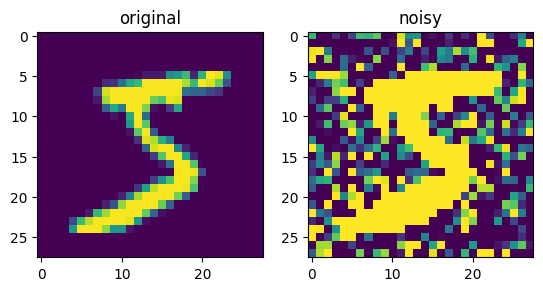

In [6]:
# 학습 데이터 정의
training_data = MNIST(
    root="./",
    train=True,
    download=True,
    transform=ToTensor())

# 평가 데이터 정의
test_data = MNIST(
    root="./",
    train=False,
    download=True,
    transform=ToTensor())

# 첫 번째 원본 이미지
img = training_data.data[0]
# 잡음이 섞인 이미지로 변환
gaussian = gaussian_noise(img)


# 두 이미지 출력
plt.subplot(1, 2, 1)
plt.title("original")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title("noisy")
plt.imshow(gaussian)
plt.show()

# 학습용 데이터셋

In [8]:
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
   def __init__(self):
       # 원본 이미지를 담고있는 MNIST 데이터
       self.mnist = MNIST(
           root="./",
           train=True,
           download=True,
           transform=ToTensor())
       self.data = []
       # 잡음이 낀 데이터를 담는 리스트

       # 1. 잡음 입히기
       for i in range(len(self.mnist)):
           noisy_input = gaussian_noise(self.mnist.data[i])
           input_tensor = torch.tensor(noisy_input)
           self.data.append(torch.unsqueeze(input_tensor, dim=0))
   def __len__(self):
       return len(self.data)
   def __getitem__(self, i):
       data = self.data[i]

       # 원본 이미지도 0과 1 사이로 값을 맞춰줌
       # 최대-최소 정규화 적용
       label = self.mnist.data[i]/255

       return data, label

# 합성곱 기본 블록

In [9]:
import torch.nn as nn


class BasicBlock(nn.Module):  # 4장에서 사용한 CNN 블록을 이용
   def __init__(self, in_channels, out_channels, hidden_dim):
       super(BasicBlock, self).__init__()

       self.conv1 = nn.Conv2d(
           in_channels,
           hidden_dim,
           kernel_size=3,
           padding=1)
       self.conv2 = nn.Conv2d(
           hidden_dim,
           out_channels,
           kernel_size=3,
           padding=1)
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.conv1(x)
       x = self.relu(x)
       x = self.conv2(x)
       x = self.relu(x)

       return x

# 인코더 모델

In [10]:
class Encoder(nn.Module):
   def __init__(self):
       super(Encoder, self).__init__()

       # ❶ 입력 채널이 1인 것에 주의
       self.conv1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim=16)
       self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)

       self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

   def forward(self, x):  # CNN과 동일하게 합성곱층을 거치고 풀링을 해줌
       x = self.conv1(x)
       x = self.pool(x)
       x = self.conv2(x)
       x = self.pool(x)

       return x

# 디코더 모델

In [11]:
class Decoder(nn.Module):
   def __init__(self):
       super(Decoder, self).__init__()
       self.conv1 = BasicBlock(in_channels=8, out_channels=8, hidden_dim=8)
       self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16)

       # ❶출력층은 BasicBlock이 아닌 합성곱층
       self.conv3 = nn.Conv2d(in_channels=16, out_channels=1,
                              kernel_size=3, padding=1)

       # 업샘플링층
       self.upsample1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
       self.upsample2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)


   # 인코더의 풀링 대신 입력 크기를 키우는 업샘플링 이용
   def forward(self, x):
       x = self.conv1(x)
       x = self.upsample1(x)
       x = self.conv2(x)
       x = self.upsample2(x)
       x = self.conv3(x)

       return x

# CAE모델 정의하기

In [12]:
class CAE(nn.Module):
   def __init__(self):
       super(CAE, self).__init__()

       self.enc = Encoder()
       # 인코더 층의 정의
       self.dec = Decoder()
       # 디코더 층의 정의

   def forward(self, x):  # 인코더, 디코더를 거친 후, 채널 차원을 삭제
       x = self.enc(x)    # 인코더로 특징 추출
       x = self.dec(x)    # 디코더로 이미지 복원
       x = torch.squeeze(x) # 채널 차원의 삭제


       return x

# 모델 학습하기

In [13]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

trainset = Denoising()  # 학습에 이용할 데이터셋
train_loader = DataLoader(trainset, batch_size=32)  # 한 번에 이미지 32장 사용

model = CAE().to(device)  # 디노이징에 사용할 오토인코더 모델


# 학습률과 최적화를 정의
lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)

for epoch in range(20):
   iterator = tqdm.tqdm(train_loader)

   for data, label in iterator:
       optim.zero_grad()
       pred = model(data.to(device))

       loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))  # 손실의 계산
       loss.backward()  # 오차 역전파
       optim.step()  # 최적화
       iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "./CAE.pth")  # 모델의 가중치 저장

<ipython-input-5-0dc656c0a6cf>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x) # 파이토치 텐서로 변환
<ipython-input-8-575b0a59ad0f>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch20 loss:0.007740976754575968: 100%|██████████| 1875/1875 [00:14<00:00, 127.43it/s]


# 모델 성능 평가

<ipython-input-5-0dc656c0a6cf>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x) # 파이토치 텐서로 변환


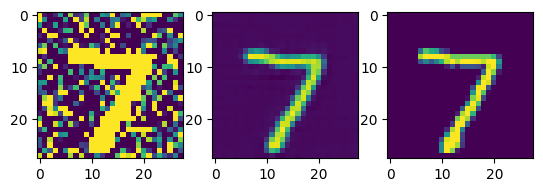

In [14]:
model.cpu()  # ❶ 모델의 출력값을 cpu로 이동

with torch.no_grad():
   # 학습이 완료된 가중치를 불러오기
   model.load_state_dict(torch.load("./CAE.pth", map_location=device))

   img = test_data.data[0]         # 시각화에 사용할 이미지 한 장을 불러오기
   gaussian = gaussian_noise(img)  # 이미지에 가우스 잡음을 입히기
   input = torch.unsqueeze(gaussian, dim=0) # 모델의 입력 모양에 맞춰 채널 차원 추가
   input.type(torch.FloatTensor)  # ❷ 가중치와 입력의 데이터형을 맞춤
   input.to(device)
   input = torch.unsqueeze(input, dim=0)  # 배치 크기1을 위한 배치 차원을 추가

   plt.subplot(1, 3, 1)
   plt.imshow(torch.squeeze(gaussian))
   plt.subplot(1, 3, 2)
   plt.imshow(torch.squeeze(model(input)))
   plt.subplot(1, 3, 3)
   plt.imshow(torch.squeeze(img))
   plt.show()